<div style="text-align: center;">

# Estonia Disaster Passanger List: EDA + Classification

<h3 align="center">Made by 🚀 <a href="https://www.kaggle.com/rafanthx13"> Rafael Morais de Assis</a></h3>
    
<img src="https://upload.wikimedia.org/wikipedia/commons/1/1a/MS_Estonia_model.jpg" width="50%"/>
    
</div> <br>


Created: 2020-08-21; 

Last updated: 2020-08-23;


## Kaggle Description

[Kaggle Link](https://www.kaggle.com/christianlillelund/passenger-list-for-the-estonia-ferry-disaster)

Read more: https://en.wikipedia.org/wiki/MS_Estonia

### Facts

When was the Sinking of the Estonia: September 28, 1994
Where was the Sinking of the Estonia: Near the Turku Archipelago, in the Baltic Sea
What was the Sinking of the Estonia death toll: 852 passengers and crew

Interesting things to investigate about the data:

Who's more likely to survive the sinking based on data?
Is age an indicator for survival?
Is gender an indicator for survival?
Did the crew aboard have a higher chance of survival than passengers?
Since the death toll is well above 80%, can you make a classifier that beats the baseline (all passengers died)?

### Data Dictionary

| Variable  | Definition                              | Key                     |
| :-------- | :-------------------------------------- | :---------------------- |
| Country   | Country of origin                       |                         |
| Firstname | Firstname of passenger                  |                         |
| Lastname  | Lastname of passenger                   |                         |
| Sex       | Gender of passenger                     | M = Male, F = Female    |
| Age       | Age of passenger at the time of sinking |                         |
| Category  | The type of passenger                   | C = Crew, P = Passenger |
| Survived  | Survival                                | 0 = No, 1 = Yes   

## Table Of Contents (TOC) <a id="top"></a>

+ [Import Libs and DataSet](#index01) 
+ [Snippets](#index02)
+ [EDA](#index03)
  - [Check Missing Data](#index04)
  - [Check Duplicate Data](#index05)
  - [Each Feature Individually](#index06)
  - [With Survived](#index07)
+ [Correlation](#index11)
+ [Unbalanced DataSet](#index09)
+ [Pre-Processing](#index23)
+ [Split in Train Test a Unbalanced DataSet](#index24)
+ [Test various ways to correct unbalanced dataset](#index25)
+ [Fit multiple models and Compare](#index26)
+ [Best Individual Model: AdaBoost](#index27)
+ [Super Leaner (MLens)](#index28)
+ [Save and Load a Model](#index29)
+ [Conclusion](#index30)


## Import Libs and DataSet Snippets <a id='index01'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.options.display.float_format = '{:,.4f}'.format
sns.set(style="whitegrid")

/kaggle/input/passenger-list-for-the-estonia-ferry-disaster/estonia-passenger-list.csv


In [2]:
df = pd.read_csv("/kaggle/input/passenger-list-for-the-estonia-ferry-disaster/estonia-passenger-list.csv")
print("Shape of DataSet:", df.shape[0], 'rows |', df.shape[1], 'columns')
df.head()

Shape of DataSet: 989 rows | 8 columns


PassengerId  Country        Firstname  Lastname Sex  Age Category  Survived
0            1   Sweden      ARVID KALLE     AADLI   M   62        P         0
1            2  Estonia              LEA   AALISTE   F   22        C         0
2            3  Estonia             AIRI   AAVASTE   F   21        C         0
3            4   Sweden             JURI     AAVIK   M   53        C         0
4            5   Sweden  BRITTA ELISABET  AHLSTROM   F   55        P         0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  989 non-null    int64 
 1   Country      989 non-null    object
 2   Firstname    989 non-null    object
 3   Lastname     989 non-null    object
 4   Sex          989 non-null    object
 5   Age          989 non-null    int64 
 6   Category     989 non-null    object
 7   Survived     989 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 61.9+ KB


In [4]:
df.describe().T

count     mean      std    min      25%      50%      75%  \
PassengerId 989.0000 494.9929 285.6437 1.0000 248.0000 495.0000 742.0000   
Age         989.0000  44.5753  17.2351 0.0000  30.0000  44.0000  59.0000   
Survived    989.0000   0.1385   0.3456 0.0000   0.0000   0.0000   0.0000   

                 max  
PassengerId 989.0000  
Age          87.0000  
Survived      1.0000

## Snippets <a id='index02'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [5]:
def eda_categ_feat_desc_plot(series_categorical, title = ""):
    """Generate 2 plots: barplot with quantity and pieplot with percentage. 
       @series_categorical: categorical series
       @title: optional
    """
    series_name = series_categorical.name
    val_counts = series_categorical.value_counts()
    val_counts.name = 'quantity'
    val_percentage = series_categorical.value_counts(normalize=True)
    val_percentage.name = "percentage"
    val_concat = pd.concat([val_counts, val_percentage], axis = 1)
    val_concat.reset_index(level=0, inplace=True)
    val_concat = val_concat.rename( columns = {'index': series_name} )
    
    fig, ax = plt.subplots(figsize = (12,4), ncols=2, nrows=1) # figsize = (width, height)
    if(title != ""):
        fig.suptitle(title, fontsize=18)
        fig.subplots_adjust(top=0.8)

    s = sns.barplot(x=series_name, y='quantity', data=val_concat, ax=ax[0])
    for index, row in val_concat.iterrows():
        s.text(row.name, row['quantity'], row['quantity'], color='black', ha="center")

    s2 = val_concat.plot.pie(y='percentage', autopct=lambda value: '{:.2f}%'.format(value),
                             labels=val_concat[series_name].tolist(), legend=None, ax=ax[1],
                             title="Percentage Plot")

    ax[1].set_ylabel('')
    ax[0].set_title('Quantity Plot')

    plt.show()

In [6]:
def eda_horiz_plot(df, x, y, title, figsize = (8,5), palette="Blues_d", formating="int"):
    """Using Seaborn, plot horizonal Bar with labels
    !!! Is recomend sort_values(by, ascending) before passing dataframe
    !!! pass few values, not much than 20 is recommended
    """
    f, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=x, y=y, data=df, palette=palette)
    ax.set_title(title)
    for p in ax.patches:
        width = p.get_width()
        if(formating == "int"):
            text = int(width)
        else:
            text = '{.2f}'.format(width)
        ax.text(width + 1, p.get_y() + p.get_height() / 2, text, ha = 'left', va = 'center')
    plt.show()

In [7]:
def eda_categ_feat_desc_df(series_categorical):
    """Generate DataFrame with quantity and percentage of categorical series
    @series_categorical = categorical series
    """
    series_name = series_categorical.name
    val_counts = series_categorical.value_counts()
    val_counts.name = 'quantity'
    val_percentage = series_categorical.value_counts(normalize=True)
    val_percentage.name = "percentage"
    val_concat = pd.concat([val_counts, val_percentage], axis = 1)
    val_concat.reset_index(level=0, inplace=True)
    val_concat = val_concat.rename( columns = {'index': series_name} )
    return val_concat

In [8]:
def eda_numerical_feat(series, title="", with_label=True, number_format=""):
    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 5), sharex=False)
    print(series.describe())
    if(title != ""):
        f.suptitle(title, fontsize=18)
    sns.distplot(series, ax=ax1)
    sns.boxplot(series, ax=ax2)
    if(with_label):
        describe = series.describe()
        labels = { 'min': describe.loc['min'], 'max': describe.loc['max'], 
              'Q1': describe.loc['25%'], 'Q2': describe.loc['50%'],
              'Q3': describe.loc['75%']}
        if(number_format != ""):
            for k, v in labels.items():
                ax2.text(v, 0.3, k + "\n" + number_format.format(v), ha='center', va='center', fontweight='bold',
                         size=8, color='white', bbox=dict(facecolor='#445A64'))
        else:
            for k, v in labels.items():
                ax2.text(v, 0.3, k + "\n" + str(v), ha='center', va='center', fontweight='bold',
                     size=8, color='white', bbox=dict(facecolor='#445A64'))
    plt.show()

In [9]:
def check_balanced_train_test_binary(x_train, y_train, x_test, y_test, original_size, labels):
    """ To binary classification
    each paramethes is pandas.core.frame.DataFrame
    @total_size = len(X) before split
    @labels = labels in ordem [0,1 ...]
    """
    train_unique_label, train_counts_label = np.unique(y_train, return_counts=True)
    test_unique_label, test_counts_label = np.unique(y_test, return_counts=True)

    prop_train = train_counts_label/ len(y_train)
    prop_test = test_counts_label/ len(y_test)

    print("Original Size:", '{:,d}'.format(original_size))
    print("\nTrain: must be 80% of dataset:\n", 
          "the train dataset has {:,d} rows".format(len(x_train)),
          'this is ({:.2%}) of original dataset'.format(len(x_train)/original_size),
                "\n => Classe 0 ({}):".format(labels[0]), train_counts_label[0], '({:.2%})'.format(prop_train[0]), 
                "\n => Classe 1 ({}):".format(labels[1]), train_counts_label[1], '({:.2%})'.format(prop_train[1]),
          "\n\nTest: must be 20% of dataset:\n",
          "the test dataset has {:,d} rows".format(len(x_test)),
          'this is ({:.2%}) of original dataset'.format(len(x_test)/original_size),
                  "\n => Classe 0 ({}):".format(labels[0]), test_counts_label[0], '({:.2%})'.format(prop_test[0]),
                  "\n => Classe 1 ({}):".format(labels[1]),test_counts_label[1], '({:.2%})'.format(prop_test[1])
         )

In [10]:
def class_report(y_target, y_preds, name="", labels=None):
    if(name != ''):
        print(name,"\n")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=labels))

## Exploratory Data Analysis <a id='index03'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

### Missing Data

In [11]:
print("No Missing Data:")

print("\t", df.isnull().sum().max(), "invalid Data")

No Missing Data:
	 0 invalid Data


### Check Duplicate


In [12]:
# No duplicate Rows
print("Check duplicated rows")
print("\t", df.duplicated(subset=None, keep='first').sum(), 'rows Duplicates')

Check duplicated rows
	 0 rows Duplicates


### Each Feature Individually <a id='index06'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

<span style='font-size: 15pt'>PassengerId</span>

In [13]:
df['PassengerId'].value_counts()

463    2
767    2
989    1
338    1
336    1
      ..
654    1
653    1
652    1
651    1
1      1
Name: PassengerId, Length: 987, dtype: int64

In [14]:
df.query('PassengerId in [463, 767]')

PassengerId  Country  Firstname Lastname Sex  Age Category  Survived
462          463  Estonia      RAIVO     LASS   M   41        P         0
468          463  Estonia       AINA      LEE   F   26        P         1
766          767  Estonia  ALEXANDER     SALU   M   34        C         0
767          767  Estonia      SIIRI     SAME   F   25        C         1

<span style='font-size: 15pt'>Country</span>

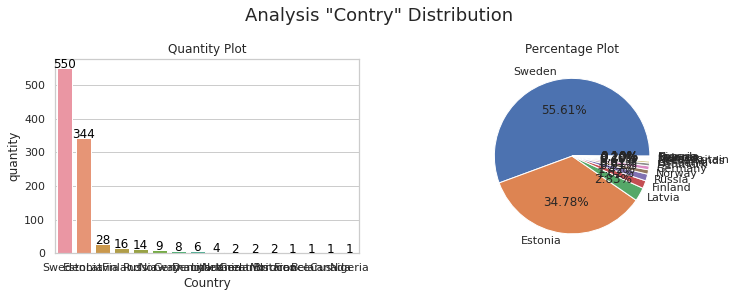

In [15]:
eda_categ_feat_desc_plot(df['Country'], 'Analysis "Contry" Distribution')

In [16]:
eda_categ_feat_desc_df(df['Country'])

Country  quantity  percentage
0          Sweden       550      0.5561
1         Estonia       344      0.3478
2          Latvia        28      0.0283
3         Finland        16      0.0162
4          Russia        14      0.0142
5          Norway         9      0.0091
6         Germany         8      0.0081
7         Denmark         6      0.0061
8       Lithuania         4      0.0040
9     Netherlands         2      0.0020
10  Great Britain         2      0.0020
11        Morocco         2      0.0020
12         France         1      0.0010
13        Belarus         1      0.0010
14         Canada         1      0.0010
15        Nigeria         1      0.0010

<span style='font-size: 15pt'>Firstname</span>

In [17]:
df_names = eda_categ_feat_desc_df(df['Firstname'])
print("unique first names: ", df_names.shape[0] )
df_names.head()

unique first names:  849


Firstname  quantity  percentage
0     RAIVO         8      0.0081
1    ANDRES         8      0.0081
2     TIINA         8      0.0081
3      PAUL         6      0.0061
4    KATRIN         6      0.0061

<span style='font-size: 15pt'>Lastname</span>

In [18]:
df_names = eda_categ_feat_desc_df(df['Lastname'])
print("unique last names: ", df_names.shape[0] )
df_names.head()

unique last names:  774


Lastname  quantity  percentage
0  ANDERSSON        15      0.0152
1    NILSSON        12      0.0121
2   ERIKSSON        11      0.0111
3   KARLSSON         9      0.0091
4  JOHANSSON         9      0.0091

<span style='font-size: 15pt'>Sex</span>

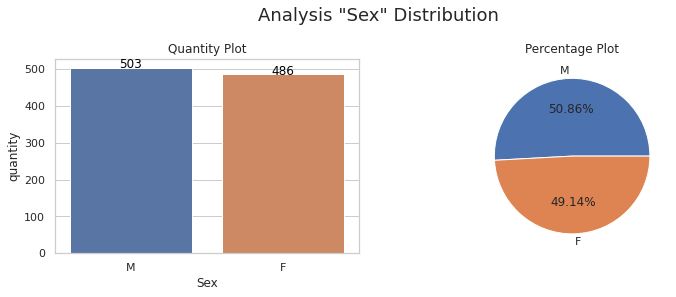

In [19]:
eda_categ_feat_desc_plot(df['Sex'], 'Analysis "Sex" Distribution')

<span style='font-size: 15pt'>Age</span>

count   989.0000
mean     44.5753
std      17.2351
min       0.0000
25%      30.0000
50%      44.0000
75%      59.0000
max      87.0000
Name: Age, dtype: float64


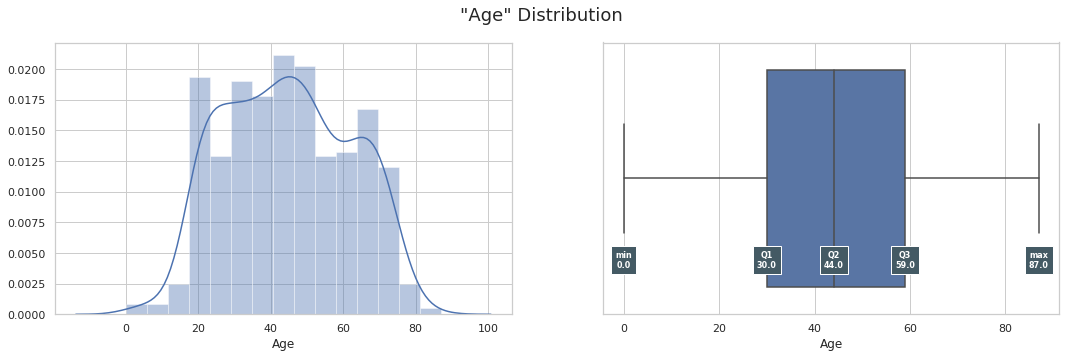

In [20]:
eda_numerical_feat(df['Age'], '"Age" Distribution', with_label=True)

In [21]:
# Min Ages and Max Ages
top_int = 5

pd.concat([df.sort_values(by="Age").head(top_int), df.sort_values(by="Age").tail(top_int)])

PassengerId  Country                Firstname   Lastname Sex  Age  \
969          970  Estonia                    KATRE     ZELMIN   F    0   
970          971  Estonia                    KRETE     ZELMIN   F    2   
335          336   Latvia                  MIHAILS       KACS   M    4   
84            85   Latvia                   NIKOLA    BIRSANE   M    5   
491          492   Sweden  KARIN GUNNELA MATSDOTTE    LINDAHL   F    5   
225          226   Sweden            ARMILDA ALICE       HAIN   F   80   
147          148   Sweden     BRITTA MARIA TEQDORA   ERIKSSON   F   81   
308          309   Sweden            MAJA KRISTINA  JOHANSSON   F   82   
818          819   Sweden      DAGNY JOHNY GUSTAVA   STENGARD   F   82   
987          988   Sweden                       LY    GUNAPUU   F   87   

    Category  Survived  
969        P         0  
970        P         0  
335        P         0  
84         P         0  
491        P         0  
225        P         0  
147        P         0  
308        P         0  
818        P         0  
987        P         0

<span style='font-size: 15pt'>Category</span>

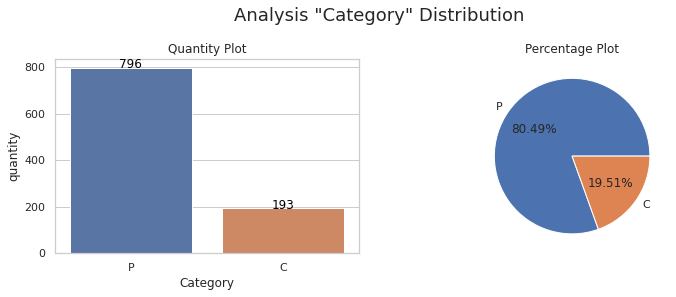

In [22]:
eda_categ_feat_desc_plot(df['Category'], 'Analysis "Category" Distribution')

<span style='font-size: 15pt'>Survived</span>

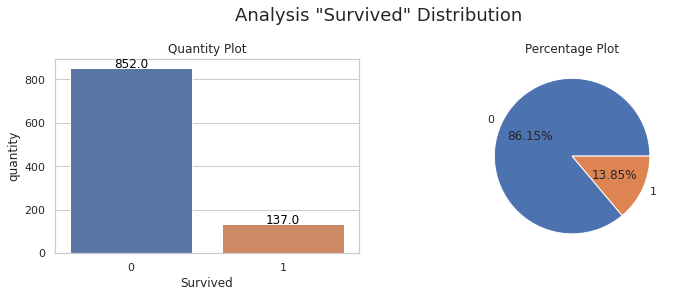

In [23]:
eda_categ_feat_desc_plot(df['Survived'], 'Analysis "Survived" Distribution')

<span style='font-size: 15pt; color: darkblue;'>Conclusion</span>

+ `PassengerId`:
   - Number and unique values for each passenger. Except 2 Ids, \[463, 767 \] these divided between a man and a woman of class mems, probably known. The curious thing is that, even though Ids are different and of different categories \[P (Passenger - Passenger), C (Crew - Technical Team)\] in both cases the woman survived and the man did not.
+ `Country`:
   - 90% of Estonia (35%) and Sweden (55%) and the rest of other countries
+ `Firstname`:
   - Unique values, there is nothing to be analyzed
+ `Lastname`:
   - Unique values, there is nothing to be analyzed
+ `Sex`:
   - On the ship, there was the same disposition between men and women
+ `Age`:
   - Most adults, with children and old people. Ages range from 0 years to 80
+ `Category`:
   - About 80% class P and 20% class C
+ `Survived`: Class
   - 806% died and 14% survived


*PassengerId*, *Firstname*, *Lastname* will no longer be analyzed for not providing relevant information to the problem

<!--
🇧🇷

+ `PassengerId`:
  -  Númerico e valores únicos para cada passageiros. Exceto 2 Ids, \[463, 767\] esses divididos entre um homem e uma mulher de mems classe, provavelmente conhecidos. O curioso é que, mesmo sendo Ids diferente e de categorias diferentes \[P (Passenger - Passageiro), C (Crew - Equipe Técnica)\] em ambos os casos a mulher sobreviveu e o homem não.
+ `Country`: 
  -  90% da Estonia (35%) e Suécia (55%) e o restante de outros paises
+ `Firstname`:
  - Valores únicos, não há o que ser analizado
+ `Lastname`:
  - Valores únicos, não há o que ser analizado
+ `Sex`:
  - No navio, havia mesma disposição entre homens e mulheres
+ `Age`:
  - Maioria Adultos, com crianças e velhos. Idades variam entre 0 anos a 80
+ `Category`:
  - Cerca de 80% classe P e 20% classe C
+ `Survived`: Classe
  - 806% morreram e 14% sobreviveram


*PassengerId*, *Firstname*, *Lastname* não serão mais analizados por não oferencerem informação relevante ao problema
-->

### With Survived <a id='index02'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>


In [24]:
print(list(df.columns))

['PassengerId', 'Country', 'Firstname', 'Lastname', 'Sex', 'Age', 'Category', 'Survived']


<span style='font-size: 15pt'>Relationship Sex, Age and Survived</span>

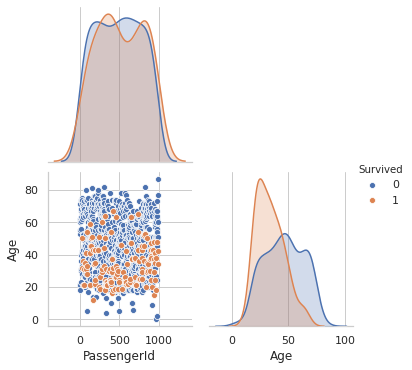

In [25]:
sns.pairplot(df, hue="Survived", corner=True)

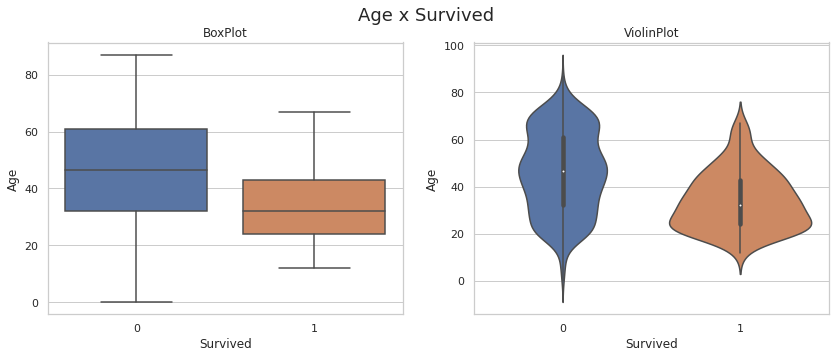

In [26]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5), sharex=False)
f.suptitle('Age x Survived', fontsize=18)

sns.boxplot(y="Age", x="Survived", data=df, ax=ax1)
sns.violinplot(y="Age", x="Survived", data=df, ax=ax2)
ax1.set_title("BoxPlot")
ax2.set_title("ViolinPlot")

plt.show()

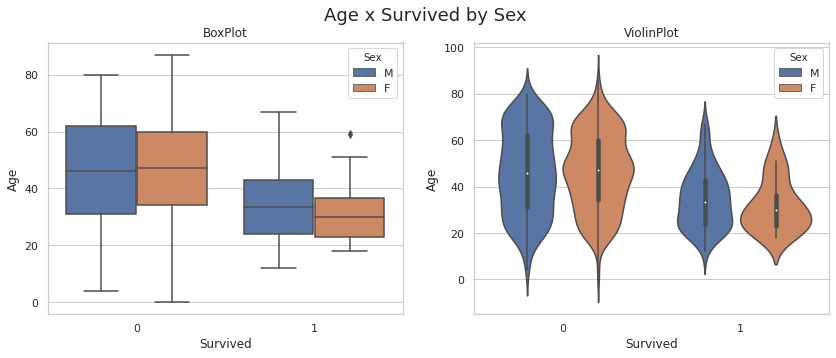

In [27]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5), sharex=False)
f.suptitle('Age x Survived by Sex', fontsize=18)

sns.boxplot(y="Age", x="Survived", hue="Sex", data=df, ax=ax1)
sns.violinplot(y="Age", x="Survived", hue="Sex", data=df, ax=ax2)
ax1.set_title("BoxPlot")
ax2.set_title("ViolinPlot")

plt.show()

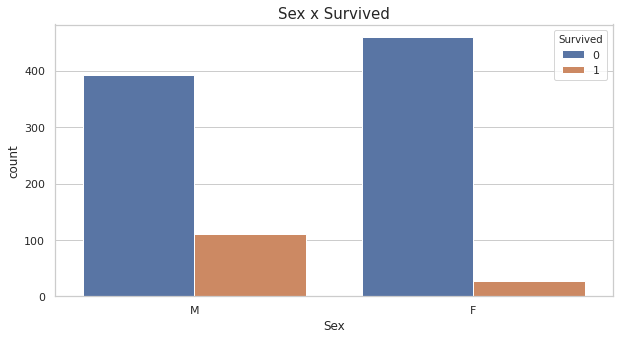

In [28]:
f, ax1 = plt.subplots(figsize=(10, 5))

sns.countplot(x="Sex", hue="Survived", data=df, ax=ax1)
ax1.set_title("Sex x Survived", size=15)

plt.show()

<span style='font-size: 15pt; color: darkblue;'>Conclusion</span>

Analyzing the BoxPlots and ViolinPlots, we can see that younger people tended to survive, and this occurs mainly for women

<!--
Analisandos os BoxPlots e ViolinPlots podemos perceber que pessoas mais jovens tenderam a sobreviver, e isso ocorre principalmente para as mulheres
-->

<span style='font-size: 15pt'>features x Survived</span>

In [29]:
df1 = df.groupby(["Survived","Sex"]).count().reset_index().rename({"Firstname": "Quantity"}, axis=1)
df1

Survived Sex  PassengerId  Country  Quantity  Lastname  Age  Category
0         0   F          459      459       459       459  459       459
1         0   M          393      393       393       393  393       393
2         1   F           27       27        27        27   27        27
3         1   M          110      110       110       110  110       110

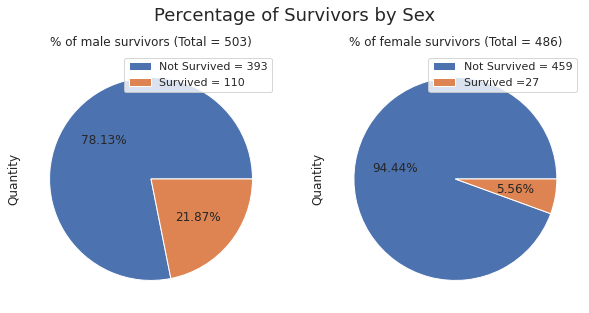

In [30]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 5), sharex=False)
f.suptitle('Percentage of Survivors by Sex', fontsize=18)

alist = df1['Quantity'].tolist()

df1.query('Sex == "M"').plot.pie(y='Quantity', figsize=(10, 5), autopct='%1.2f%%', 
                                 labels = ['Not Survived = ' + str(alist[1]), 'Survived = ' + str(alist[3]) ],
                                 title="% of male survivors " + "(Total = " + str(alist[1] + alist[3]) + ")",
                                 ax=ax1, labeldistance=None)

df1.query('Sex == "F"').plot.pie(y='Quantity', figsize=(10, 5), autopct='%1.2f%%', 
                                 labels = ['Not Survived = ' + str(alist[0]), 'Survived =' + str(alist[2]) ],
                                title="% of female survivors " + "(Total = " + str(alist[0] + alist[2]) + ")", 
                                 ax=ax2, labeldistance=None)

plt.show()

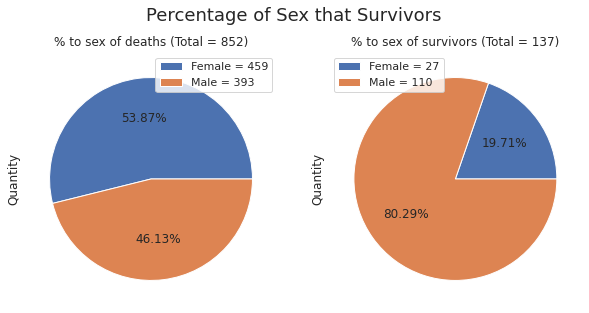

In [31]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 5), sharex=False)
f.suptitle('Percentage of Sex that Survivors', fontsize=18)

alist = df1['Quantity'].tolist()

df1.query('Survived == 0').plot.pie(y='Quantity', figsize=(10, 5), autopct='%1.2f%%',
                                    labels = ['Female = ' + str(alist[0]), 'Male = ' + str(alist[1]) ],
                                    title="% to sex of deaths " + "(Total = " + str(alist[0] + alist[1]) + ")",
                                    ax=ax1, labeldistance=None)

df1.query('Survived == 1').plot.pie(y='Quantity', figsize=(10, 5), autopct='%1.2f%%',
                                    labels = ['Female = ' + str(alist[2]), 'Male = ' + str(alist[3]) ],
                                    title="% to sex of survivors "  + "(Total = " + str(alist[2] + alist[3]) + ")",
                                    ax=ax2, labeldistance=None)

plt.show()

In [32]:
df2 = df.groupby(["Survived","Category"]).count().reset_index().rename({"Firstname": "Quantity"}, axis=1)
df2

Survived Category  PassengerId  Country  Quantity  Lastname  Sex  Age
0         0        C          154      154       154       154  154  154
1         0        P          698      698       698       698  698  698
2         1        C           39       39        39        39   39   39
3         1        P           98       98        98        98   98   98

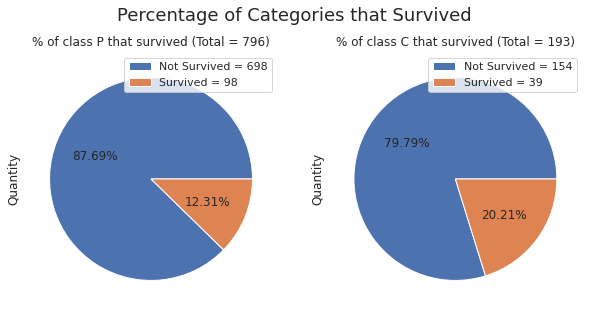

In [33]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 5), sharex=False)
f.suptitle('Percentage of Categories that Survived', fontsize=18)

alist = df2['Quantity'].tolist()

df2.query('Category == "P"').plot.pie(y='Quantity', figsize=(10, 5), autopct='%1.2f%%',
                                      labels = ['Not Survived = ' + str(alist[1]), 'Survived = ' + str(alist[3]) ],
                                      title="% of class P that survived " + "(Total = " + str(alist[1] + alist[3]) + ")",
                                      ax=ax1, labeldistance=None)

df2.query('Category == "C"').plot.pie(y='Quantity', figsize=(10, 5), autopct='%1.2f%%',
                                      labels = ['Not Survived = ' + str(alist[0]), 'Survived = ' + str(alist[2]) ],
                                      title="% of class C that survived " + "(Total = " + str(alist[0] + alist[2]) + ")",
                                      ax=ax2, labeldistance=None)

plt.show()

<span style='font-size: 15pt; color: darkblue;'>Conclusion</span>

Percentage of Survivors by Sex
+ Men tended to outlive women

Percentage of Sex that Survivors
+ The percentage of deaths is similar between genders, 43% of women died and 46% of men died, but of the survivors, the majority who survived were men
+ probably, the previous graphics of violin plot that spoke of the young age of the women who survived, referred to a few women

Percentage of Categories that Survived
+ Although more passengers have survived (because there are 4x more passengers than people on the technical team), the technical team (Crew) had a higher survival rate.


<!--
Percentage of Survivors by Sex
+ Os homens tenderam a sobreviver mais que as mulheres

Percentage of Sex that Survivors
+ A porcentagem de mortes é parecida entre os sexo, 43% das mulhres morreram e 46% dos homens morreram, mas dos sobreviventes, a maioria que sobreviveu foram homens
+ provavelmente, os graficos anteriores de violin plot que falaram de pouca idade das mulheres que sobreviream, se referiam a poucas mulhres

Percentage of Categories that Survived
+ Apesar de mais passageiros terem sobrevivido (Pois há 4x mais passageiros que gente da equipe técnica), a equipe técnica (Crew) apresentram uma maior taxa de sobrevivência.
-->

## Correlation <a id='index11'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [34]:
replace_list = {"Sex":{"M":0,"F":1}, "Category":{"P":0,"C":1}}

df_corr = df.replace(replace_list).drop(['PassengerId', 'Country','Firstname','Lastname'], axis = 1)
df_corr.head(3)

Sex  Age  Category  Survived
0    0   62         0         0
1    1   22         1         0
2    1   21         1         0

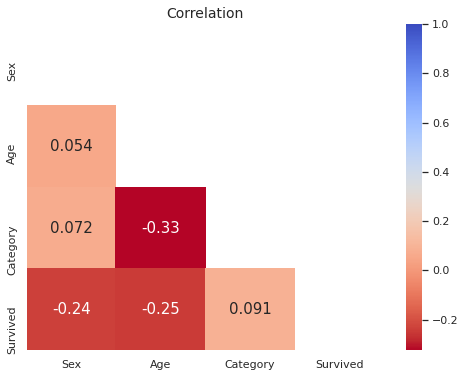

In [35]:
corr = df_corr.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax1 = plt.subplots(figsize=(8,6))
sns.heatmap(corr, cmap='coolwarm_r', 
            annot=True, annot_kws={'size':15}, ax=ax1, mask=mask)

ax1.set_title("Correlation", fontsize=14)

plt.show()

As correlações são em sua maioria fraca, mas a melhor é 'Age'

## Unbalanced DataSet <a id='index09'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

Significa que, se se chutarmos sempre que todo mundo vai morrer, então: Nunca teriamos acertariamos que alguem iria sobreveier e teriamos um score de 87% que é alto. Uma métrica melhor para avliar as duas tarefas do modelo: Classifica se sobrivive ou nâo corretamente, é usar f1-score que avalia precisao (acerta) e recall (detectar)

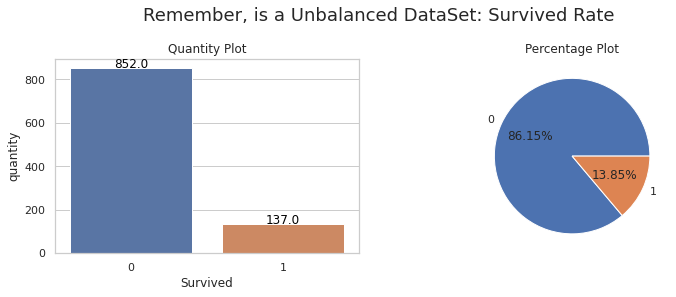

In [36]:
eda_categ_feat_desc_plot(df['Survived'], 'Remember, is a Unbalanced DataSet: Survived Rate')



## Pre-Processing <a id='index23'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>


In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

### Commun Pre-Processing

Take Sex, Age and Category

Medium Results

In [38]:
# x = df.loc[:,["Sex","Age","Category"]]
# y = df.loc[:,["Survived"]]

# # OneHotEncoding
# x = pd.get_dummies(x)

# # Scaling Age
# sc = StandardScaler()  # Normal Distribution: mean 0, min -1 and max 1
# x['Age'] = sc.fit_transform(x['Age'].values.reshape(-1,1))

# x.head(3)

### Country Influence Pre-Processing (BEST)

Based in https://www.kaggle.com/abhijithchandradas/pen-random-forest-model-beating-baseline-88-47

Make good Results

In [39]:
x = df.loc[:,["Sex","Age","Category","Country"]]
y = df.loc[:,["Survived"]]

x.head(1)

Sex  Age Category Country
0   M   62        P  Sweden

In [40]:
# Separate Country in Estonia, Sweden and Others
x['Country'] = x['Country'].apply(lambda x: 'Estonia' if x == 'Estonia' 
                                  else ('Sweden' if x == 'Sweden' else 'Others'))

sc = StandardScaler()  # Normal Distribution: mean 0, min -1 and max 1
x['Age'] = sc.fit_transform(x['Age'].values.reshape(-1,1))

x = pd.get_dummies(x, drop_first=True) # Remove EstoniaColumn

x.head(3)

Age  Sex_M  Category_P  Country_Others  Country_Sweden
0  1.0115      1           1               0               1
1 -1.3105      0           0               0               0
2 -1.3686      0           0               0               0

### LastName Pre-Processing

Include LastName encodig with label encondig (0,1,2,3 ... to each unique value)

Made Poor Results

In [41]:
# x = df.loc[:,["Sex","Age","Category","Country", "Lastname"]]
# y = df.loc[:,["Survived"]]

# x['Country']= [1 if el =='Estonia' or el =='Sweden' else 0 for el in x['Country']] 

# sc = StandardScaler()  
# x['Age'] = sc.fit_transform(x['Age'].values.reshape(-1,1))

# encode = LabelEncoder()
# x['Sex']=encode.fit_transform(x['Sex'])
# x['Lastname']=encode.fit_transform(x['Lastname'])
# x['Category'] =encode.fit_transform(x['Category'])

# x.head(3)

## Split in Train Test a Unbalanced DataSet <a id='index24'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [42]:
from sklearn.model_selection import KFold, StratifiedKFold

kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for train_index, test_index in kfold.split(x, y):
    x_train, x_test = x.iloc[train_index].values, x.iloc[test_index].values
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values

check_balanced_train_test_binary(x_train, y_train, x_test, y_test, len(df), ['Death', 'Survives'])

Original Size: 989

Train: must be 80% of dataset:
 the train dataset has 792 rows this is (80.08%) of original dataset 
 => Classe 0 (Death): 682 (86.11%) 
 => Classe 1 (Survives): 110 (13.89%) 

Test: must be 20% of dataset:
 the test dataset has 197 rows this is (19.92%) of original dataset 
 => Classe 0 (Death): 170 (86.29%) 
 => Classe 1 (Survives): 27 (13.71%)


## Test various ways to correct unbalanced dataset <a id='index25'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

Dont produce good results, decreases accuracy and increases f1 score

To use just exchange x_train, y_train by xsm_train, ysm_train

In [43]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek # over and under sampling
from imblearn.metrics import classification_report_imbalanced

imb_models = {
    'ADASYN': ADASYN(),
    'SMOTE': SMOTE(random_state=42),
    'SMOTEENN': SMOTEENN("minority", random_state=42),
    'SMOTETomek': SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')),
    'RandomUnderSampler': RandomUnderSampler()
}

imb_strategy = "SMOTE"

if(imb_strategy != "None"):
    print("train dataset before", x_train.shape[0])
    print("imb_strategy:", imb_strategy)

    imb_tranformer = imb_models[imb_strategy]
    
    # x_train, y_train | xsm_train, ysm_train
    xsm_train, ysm_train = imb_tranformer.fit_sample(x_train, y_train)

    print("train dataset before", xsm_train.shape[0],
          'generate', xsm_train.shape[0] - x_train.shape[0] )
else:
    print("Dont correct unbalanced dataset")

train dataset before 792
imb_strategy: SMOTE
train dataset before 1364 generate 572


## Fit multiple models and Compare <a id='index26'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [44]:
# use: x_train, y_train, x_test, y_test

# Classifier Libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Ensemble Classifiers
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Others Linear Classifiers
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier

# xboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# scores
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# neural net of sklearn
from sklearn.neural_network import MLPClassifier

# others
import time
import operator

In [45]:
# def neural nets
mlp = MLPClassifier(verbose = False, max_iter=1000, tol = 0.000010,
                    solver = 'adam', hidden_layer_sizes=(100), activation='relu')

# def classifiers

nn_classifiers = {
    "Multi Layer Perceptron": mlp
}

linear_classifiers = {
    "SGDC": SGDClassifier(),
    "Ridge": RidgeClassifier(),
    "Perceptron": Perceptron(),
    "PassiveAggressive": PassiveAggressiveClassifier()
}

gboost_classifiers = {
    "XGBoost": XGBClassifier(),
    "LightGB": LGBMClassifier(),
}

classifiers = {
    "Naive Bayes": GaussianNB(),
    "Logisitic Regression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier()
}

ensemble_classifiers = {
    "AdaBoost": AdaBoostClassifier(),
    "GBoost": GradientBoostingClassifier(),
    "Bagging": BaggingClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier()    
}

all_classifiers = {
    "Simple Models": classifiers,
    "Ensemble Models": ensemble_classifiers,
    "GBoost Models": gboost_classifiers,
    "NeuralNet Models": nn_classifiers,
    "Others Linear Models": linear_classifiers,
}

metrics = {
    'cv_scores': {},
    'acc_scores': {},
    'f1_mean_scores': {},
}

In [46]:
format_float = "{:.4f}"

is_print = False # True/False

time_start = time.time()

print("Fit Many Classifiers")

for key, classifiers in all_classifiers.items():
    if (is_print):
        print("\n{}\n".format(key))
    for key, classifier in classifiers.items():
        t0 = time.time()
        # xsm_train, ysm_train || x_train, y_train
        classifier.fit(x_train, y_train) 
        t1 = time.time()
        # xsm_train, ysm_train || x_train, y_train
        training_score = cross_val_score(classifier, x_train, y_train, cv=5) 
        y_pred = classifier.predict(x_test)
        cv_score = round(training_score.mean(), 4) * 100
        acc_score = accuracy_score(y_test, y_pred)
        f1_mean_score = f1_score(y_test, y_pred, average="macro") # average =  'macro' or 'weighted'
        if (is_print):
            print(key, "\n\tHas a training score of", 
                  cv_score, "% accuracy score on CrossVal with 5 cv ")
            print("\tTesting:")
            print("\tAccuracy in Test:", format_float.format(acc_score))
            print("\tF1-mean Score:", format_float.format(f1_mean_score)) 
            print("\t\tTime: The fit time took {:.2} s".format(t1 - t0), '\n')
        metrics['cv_scores'][key] = cv_score
        metrics['acc_scores'][key] = acc_score
        metrics['f1_mean_scores'][key] = f1_mean_score
        
time_end = time.time()
        
print("\nDone in {:.5} s".format(time_end - time_start), '\n')
        
print("Best cv score:", max( metrics['cv_scores'].items(), key=operator.itemgetter(1) ))
print("Best Accuracy score:", max( metrics['acc_scores'].items(), key=operator.itemgetter(1) ))
print("Best F1 score:", max( metrics['f1_mean_scores'].items(), key=operator.itemgetter(1) ))

lists = [list(metrics['cv_scores'].values()),
         list(metrics['acc_scores'].values()),
         list(metrics['f1_mean_scores'].values())
        ]

a_columns = list(metrics['cv_scores'].keys())

df_metrics = pd.DataFrame(lists , columns = a_columns,
                    index = ['cv_scores', 'acc_scores', 'f1_scores'] )

Fit Many Classifiers

Done in 17.361 s 

Best cv score: ('Perceptron', 86.24000000000001)
Best Accuracy score: ('Support Vector Machine', 0.8629441624365483)
Best F1 score: ('Random Forest', 0.6137254901960785)


In [47]:
lists = [list(metrics['cv_scores'].values()),
         list(metrics['acc_scores'].values()),
         list(metrics['f1_mean_scores'].values())
        ]

a_columns = list(metrics['cv_scores'].keys())

dfre1 = pd.DataFrame(lists , columns = a_columns,
                    index = ['cv_scores', 'acc_scores', 'f1_scores'] )

dfre1 = dfre1.T.sort_values(by="acc_scores", ascending=False)
dfre1

cv_scores  acc_scores  f1_scores
SGDC                      83.5800      0.8629     0.4632
Support Vector Machine    86.1100      0.8629     0.4632
AdaBoost                  84.3400      0.8629     0.5535
Ridge                     85.9900      0.8629     0.4632
PassiveAggressive         84.3400      0.8528     0.4603
Logisitic Regression      85.3500      0.8528     0.4603
GBoost                    82.3200      0.8426     0.4874
Multi Layer Perceptron    85.6100      0.8426     0.5140
XGBoost                   83.5800      0.8376     0.5736
Bagging                   82.3200      0.8325     0.5693
LightGB                   83.9600      0.8325     0.5508
KNearest                  84.3500      0.8274     0.5270
Perceptron                86.2400      0.8173     0.5877
Random Forest             82.4500      0.8173     0.6137
Extra Trees               82.1900      0.8173     0.5570
Decision Tree             82.0700      0.8173     0.5570
Naive Bayes               80.9400      0.7817     0.5313

## Best Individual Model: AdaBoost <a id='index27'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [48]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# AdaBoost
adaB = AdaBoostClassifier()
adaB.fit(x_train,y_train)
y_pred = adaB.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Death', 'Survives']))

[[167   3]
 [ 24   3]]
              precision    recall  f1-score   support

       Death       0.87      0.98      0.93       170
    Survives       0.50      0.11      0.18        27

    accuracy                           0.86       197
   macro avg       0.69      0.55      0.55       197
weighted avg       0.82      0.86      0.82       197



## Super Learner (MLens) <a id='index28'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

reference: https://www.kaggle.com/nishantbhadauria/meta-learner-with-mlens-for-predicting-survival

link to see more of SuperLeaner of mlens
+ https://machinelearningmastery.com/super-learner-ensemble-in-python/
+ http://flennerhag.com/

Generates different results each time it is run

In [49]:
from mlens.ensemble import SuperLearner

# Define Models List
models = list()
models.append(LogisticRegression(solver='liblinear'))
models.append(DecisionTreeClassifier())
models.append(SVC(kernel='linear'))
models.append(GaussianNB())
models.append(KNeighborsClassifier())
models.append(AdaBoostClassifier())    
models.append(BaggingClassifier(n_estimators=100))
models.append(RandomForestClassifier(n_estimators=100))
models.append(ExtraTreesClassifier(n_estimators=100))
models.append(XGBClassifier(scale_pos_weight=2))

# Create Super Model
ensemble = SuperLearner(scorer=accuracy_score, folds=10, shuffle=False, sample_size=len(x))
ensemble.add(models)
ensemble.add_meta(DecisionTreeClassifier()) # can change

# Fit 
ensemble.fit(x_train, y_train)
print(ensemble.data)

# Pred
y_pred = ensemble.predict(x_test)

# Evaluate
class_report(y_test, y_pred, name='SuperLeaner', labels=['Death', 'Survives'])

# One time out: acc: 0.89, f1: 0.59

[MLENS] backend: threading


                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  adaboostclassifier           0.85     0.04  1.35  0.10  0.02  0.01
layer-1  baggingclassifier            0.83     0.03  2.34  0.24  0.05  0.01
layer-1  decisiontreeclassifier       0.83     0.04  0.02  0.01  0.00  0.00
layer-1  extratreesclassifier         0.82     0.05  1.39  0.20  0.03  0.00
layer-1  gaussiannb                   0.81     0.04  0.01  0.00  0.00  0.00
layer-1  kneighborsclassifier         0.83     0.04  0.00  0.00  0.04  0.01
layer-1  logisticregression           0.85     0.04  0.01  0.00  0.00  0.00
layer-1  randomforestclassifier       0.83     0.04  1.62  0.08  0.04  0.02
layer-1  svc                          0.86     0.05  0.01  0.00  0.00  0.00
layer-1  xgbclassifier                0.81     0.03  0.29  0.06  0.02  0.01

SuperLeaner 

[[170   0]
 [ 26   1]]
              precision    recall  f1-score   support

       Death       0.87      1.00      0.93       170
    Survives     

## Save and Load Model <a id='index29'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

In [50]:
import pickle
Pkl_Filename = "Pickle_Model.pkl"  

# Save the Modle to file in the current working directory
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(ensemble, file)
    
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_ensemble = pickle.load(file)

Pickled_ensemble

SuperLearner(array_check=None, backend=None, folds=10,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=10, raise_on_e...00649e0>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=989,
       scorer=<function accuracy_score at 0x7f36f00649e0>, shuffle=False,
       verbose=False)

## Conclusion <a id='index30'></a> <a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white; margin-left: 20px;" data-toggle="popover">Go to TOC</a>

The best strategy to achieve the highest accuracy was:
+ Pre-Processing
   - OneHotEnconding to Country and remove Estonia Column.
   - LabelEnconding to 'Sex' and 'Category'
   - StandScale to 'Age'
+ Do not use any corrected unbalanced data set technique because it decreases accuracy to increase f1-score
+ The best model was the SuperLeaner that combines several models, while individually it was AdaBoost

**Nexts Steps**

+ Tuning AdaBoost and SuperLeaner